This notebook is used to demonstrate the creation of the initial conditions for the North Atlantic regional model. 

The approach in this notebook is similar to the notebook for the California regional model except for two key difference:
1. Seaice variables are included in this procedure
2. No assumption is made regarding the orientation of the grid for vector properties.

First, import packages to create and visualize the model fields here:

In [35]:
# import the modules for computation, plotting, and reading files
import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4

# import the necessary modules from eccoseas
from eccoseas.ecco import io
from eccoseas.ecco import grid
from eccoseas.downscale import hFac
from eccoseas.downscale import horizontal

## Constructing the Initial Conditions
The initial conditions for this model will be generated by interpolating from a model state from the ECCO Version 5 state estimate using the **eccoseas** tools.

This construction will proceed in 6 steps:
1. download the pertinent ECCO fields
2. read the ECCO model grid
3. read in the bathymetry for the regional model as well as its grid
4. prepare the ECCO fields for interpolation
5. interpolate the ECCO fields onto the regional model grid and store each as a binary file
6. plot the interpolated fields to ensure they look as expected
7. prepare notes on the run-time options to implement this initial condition approach

### Step 1: Download the ECCO fields
To begin, we downloaded the model fields generated by the ECCO Version 5 Alpha state estimate. These fields are available [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/nctiles_monthly). For the initial conditions, we use fields from 1992, which are listed here:

| Variable | File Name |
| -------- | --------- |
|THETA|THETA/THETA_1992.nc|
|SALT|SALT/SALT_1992.nc|
|UVEL|UVELMASS/UVELMASS_1992.nc|
|VVEL|VVELMASS/VVELMASS_1992.nc|
|ETAN|ETAN/ETAN_1992.nc|

As described in the Overview, we stored these in individual directories for each variable in the following directory:

In [2]:
data_folder = '../../../data/north_atlantic'

### Step 2: Read in the ECCO grid
To read in the ECCO fields, we use the `io` module from the `eccoseas.ecco` package:

In [29]:
ecco_XC_tiles = io.read_ecco_grid_tiles_from_nc(os.path.join(data_folder, 'GRID'), var_name='XC')
ecco_YC_tiles = io.read_ecco_grid_tiles_from_nc(os.path.join(data_folder, 'GRID'), var_name='YC')
ecco_AngleCS_tiles = io.read_ecco_grid_tiles_from_nc(os.path.join(data_folder, 'GRID'), var_name='AngleCS')
ecco_AngleSN_tiles = io.read_ecco_grid_tiles_from_nc(os.path.join(data_folder, 'GRID'), var_name='AngleSN')
ecco_hFacC_tiles = io.read_ecco_grid_tiles_from_nc(os.path.join(data_folder, 'GRID'), var_name='hFacC')
ecco_hFacW_tiles = io.read_ecco_grid_tiles_from_nc(os.path.join(data_folder, 'GRID'), var_name='hFacW')
ecco_hFacS_tiles = io.read_ecco_grid_tiles_from_nc(os.path.join(data_folder, 'GRID'), var_name='hFacS')
ecco_RF_tiles = io.read_ecco_grid_tiles_from_nc(os.path.join(data_folder, 'GRID'), var_name='RF')
ecco_DRF_tiles = io.read_ecco_grid_tiles_from_nc(os.path.join(data_folder, 'GRID'), var_name='DRF')

Note here that we have read in two additional fields which were not used in the previous model construction: `AngleCS` and `AngleSN`. These fields will be important for rotating vector quantities at locations near the poles.

As described [HERE](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Plotting_Tiles.html), the ECCO grid has 13 tiles but only a few may pertain to the local area. To determine which tiles correspond to the region, I'll read in my model grid next.

### Step 3: Read in the Model Grid and Generate a Mask
Here, I will read in the regional model grid and read in the bathymetry file (see previous notebooks for details):

In [12]:
# define the input directory (see previous notebook for details)
input_dir = '../../../configurations/north_atlantic/input'

In [31]:
# define the parameters that will be used in the data file
n_rows = 360
n_cols = 180

# read in the grids that will be used in the model
ds = nc4.Dataset(os.path.join(input_dir,'north_atlantic_grid.nc'))
XC = ds.variables['XC'][:,:]
YC = ds.variables['YC'][:,:]
bathy = -1*ds.variables['Depth'][:,:]
AngleCS = ds.variables['AngleCS'][:,:]
AngleSN = ds.variables['AngleSN'][:,:]
ds.close()

Note that, just like for the ECCO grid, we also read in the orientation of the grid.

Next, we will make masks to determine where the interpolatation will take place. We will create this mask by recreating the `hFac` field for the model using the `hFac` module from the `eccoseas` package: 

In [14]:
# this model will use the same vertical spacing as the ECCO Version 5 configuration
delR = ecco_DRF_tiles[1]

# generate the hFac grids - this may take a few minutes
hFacC = hFac.create_hFacC_grid(bathy, delR)
hFacS = hFac.create_hFacS_grid(bathy, delR)
hFacW = hFac.create_hFacW_grid(bathy, delR)

The mask is generated by setting all of the non-zero `hFac` points to 1:

In [15]:
# generate the masks
maskC = np.copy(hFacC)
maskC[maskC>0] = 1

maskS = np.copy(hFacS)
maskS[maskS>0] = 1

maskW = np.copy(hFacW)
maskW[maskW>0] = 1

To double check the mask was created as expected, I will plot it in comparison to the bathymetry here:

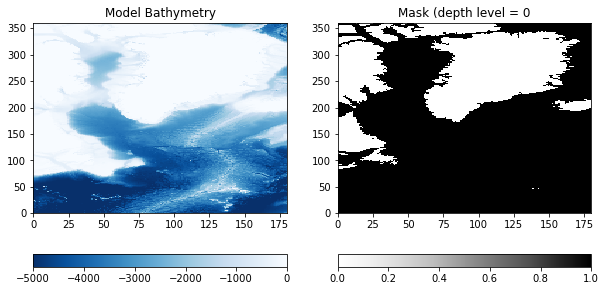

In [23]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(bathy, vmin=-5000, vmax=0, cmap='Blues_r', shading='auto')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

depth_level = 0
plt.subplot(1,2,2)
C = plt.pcolormesh(maskC[0, :, :], vmin=0, vmax=1, cmap='Greys', shading='auto')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Mask (depth level = '+str(depth_level))

plt.show()

### Step 4: Prepare the grids for interpolation
At this point, we can use the geometry of both grids to check to see which tiles have the information we need. After referencing the ECCO geometry, I find that tiles 3, 7, and 11 have the points we need:

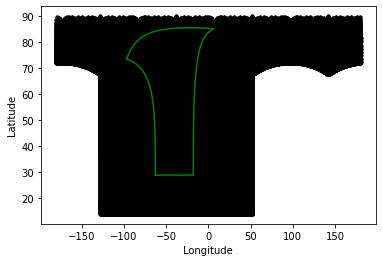

In [28]:
# formulate the tile list
tile_list = [3, 7, 11]

# plot the ECCO tile points from the specified tiles
for tile in tile_list:
    plt.plot(ecco_XC_tiles[tile],ecco_YC_tiles[tile],'k.')

# plot the ECCO tile points from tiles 3, 7 and 11
plt.plot(ecco_XC_tiles[11],ecco_YC_tiles[11],'k.')
plt.plot(ecco_XC_tiles[7],ecco_YC_tiles[7],'k.')
plt.plot(ecco_XC_tiles[3],ecco_YC_tiles[3],'k.')

# plot the boundary of the CA model
plt.plot(XC[:,0],YC[:,0], 'g-')
plt.plot(XC[:,-1],YC[:,-1], 'g-')
plt.plot(XC[0,:],YC[0,:], 'g-')
plt.plot(XC[-1,:],YC[-1,:], 'g-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

As we can see, the model boundary (green) is completely surrounded by the points in tiles 3, 7, and 11 (black). Let's read in the grid information from these tiles:

In [33]:
# the tile list
tile_list = [3,7,11]

# determine the number of points in each set
total_points = 0
for tile_number in tile_list:
    total_points += np.size(ecco_XC_tiles[tile_number])

# make empty arrays to fill in
ecco_XC_points = np.zeros((total_points, ))
ecco_YC_points = np.zeros((total_points, ))
ecco_AngleCS_points = np.zeros((total_points, ))
ecco_AngleSN_points = np.zeros((total_points, ))
ecco_maskC_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_maskW_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_maskS_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_hFacW_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_hFacS_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))

# loop through the tiles and fill in the XC, YC, and mask points for interpolation
points_counted = 0
for tile_number in tile_list:
    tile_N = np.size(ecco_XC_tiles[tile_number])
    
    ecco_XC_points[points_counted:points_counted+tile_N] = ecco_XC_tiles[tile_number].ravel()
    ecco_YC_points[points_counted:points_counted+tile_N] = ecco_YC_tiles[tile_number].ravel()

    ecco_AngleCS_points[points_counted:points_counted+tile_N] = ecco_AngleCS_tiles[tile_number].ravel()
    ecco_AngleSN_points[points_counted:points_counted+tile_N] = ecco_AngleSN_tiles[tile_number].ravel()
    
    for k in range(np.size(ecco_RF_tiles[tile_number])):
        level_hFacC = ecco_hFacC_tiles[tile_number][k, :, :]
        if tile_number<7:
            level_hFacW = ecco_hFacW_tiles[tile_number][k, :, :]
            level_hFacS = ecco_hFacS_tiles[tile_number][k, :, :]
        else:
            level_hFacS = ecco_hFacW_tiles[tile_number][k, :, :] # these are switched due to the 
            level_hFacW = ecco_hFacS_tiles[tile_number][k, :, :] # assumptions about velocity - see note below
        ecco_hFacW_points[k, points_counted:points_counted+tile_N] = level_hFacW.ravel()
        ecco_hFacS_points[k, points_counted:points_counted+tile_N] = level_hFacS.ravel()
        level_maskC = np.copy(level_hFacC)
        level_maskC[level_maskC>0] = 1
        level_maskW = np.copy(level_hFacW)
        level_maskW[level_maskW>0] = 1
        level_maskS = np.copy(level_hFacS)
        level_maskS[level_maskS>0] = 1
        ecco_maskC_points[k, points_counted:points_counted+tile_N] = level_maskC.ravel()
        ecco_maskW_points[k, points_counted:points_counted+tile_N] = level_maskW.ravel()
        ecco_maskS_points[k, points_counted:points_counted+tile_N] = level_maskS.ravel()
    
    points_counted += tile_N

Next, we'll read in the real data fields and apply the modifications. First, create a dictionary to store the file names:

In [34]:
# make a file dictionary to loop over
file_prefix_dict = {#'ETAN':'ETAN_1992.nc',
                   'THETA':'THETA_1992.nc',
                   'SALT':'SALT_1992.nc',
                   'SIarea':'SIarea_1992.nc',
                   'SIheff':'SIheff_1992.nc',
                   'SIhsnow':'SIhsnow_1992.nc',
                   'SIuice':'SIuice_1992.nc',
                   'SIvice':'SIvice_1992.nc',}
# file_prefix_dict = {'UVEL':'UVELMASS_1992.nc',
                    # 'VVEL':'VVELMASS_1992.nc'}

variable_names = list(file_prefix_dict.keys())

Now, read the initial condition fields from the same tiles:

In [24]:
# make a list to hold all of the ECCO grids
init_grids = []

# loop through each variable to read in the grid
for variable_name in variable_names:
    
    if variable_name == 'ETAN' or variable_name in ['SIarea','SIheff','SIhsnow']:
        ds = nc4.Dataset(os.path.join(data_folder,variable_name,file_prefix_dict[variable_name]))
        grid = ds.variables[variable_name][:,:,:,:]
        ds.close()
    elif 'VEL' in variable_name:
        ds = nc4.Dataset(os.path.join(data_folder,'UVELMASS','UVELMASS_1992.nc'))
        u_grid = ds.variables['UVELMASS'][:,:,:,:,:]
        ds.close()
        ds = nc4.Dataset(os.path.join(data_folder,'VVELMASS','VVELMASS_1992.nc'))
        v_grid = ds.variables['VVELMASS'][:,:,:,:,:]
        ds.close()
    elif 'ice' in variable_name:
        ds = nc4.Dataset(os.path.join(data_folder,'SIuice','SIuice_1992.nc'))
        u_grid = ds.variables['SIuice'][:,:,:,:]
        ds.close()
        ds = nc4.Dataset(os.path.join(data_folder,SIvice,'SIvice_1992.nc'))
        v_grid = ds.variables['SIvice'][:,:,:,:]
        ds.close()
    else:
        ds = nc4.Dataset(os.path.join(data_folder,variable_name,file_prefix_dict[variable_name]))
        grid = ds.variables[variable_name][:,:,:,:,:]
        ds.close()

    # create a grid of zeros to fill in
    N = np.shape(grid)[-1]*np.shape(grid)[-2]
    if variable_name == 'ETAN'  or variable_name in ['SIarea','SIheff','SIhsnow','SIuice','SIvice']:
        init_grid = np.zeros((1, N*len(tile_list)))
    else:
        init_grid = np.zeros((np.size(ecco_RF_tiles[1]), N*len(tile_list)))

    # loop through the tiles
    points_counted = 0
    for tile_number in tile_list:
        if variable_name == 'ETAN'  or variable_name in ['SIarea','SIheff','SIhsnow','SIuice','SIvice']:
            init_grid[0,points_counted:points_counted+N] = \
                 grid[0, tile_number-1, :, :].ravel()
            for k in range(np.size(ecco_RF_tiles[1])):
                init_grid[k,points_counted:points_counted+N] = \
                     grid[0, k, tile_number-1, :, :].ravel()
        points_counted += N

    # apply some corrections to convert UVELMASS and VVELMASS to UVEL and VVEL
    if variable_name == 'UVEL':
        for k in range(np.size(ecco_RF_tiles[1])):
            non_zero_indices = ecco_hFacW_points[k,:]!=0
            init_grid[k,non_zero_indices] = init_grid[k,non_zero_indices]/(ecco_hFacW_points[k,non_zero_indices])
    if variable_name == 'VVEL':
        for k in range(np.size(ecco_RF_tiles[1])):
            non_zero_indices = ecco_hFacS_points[k,:]!=0
            init_grid[k,non_zero_indices] = init_grid[k,non_zero_indices]/(ecco_hFacS_points[k,non_zero_indices])
      
    init_grids.append(init_grid)

### Step 5: Interpolate the Fields onto the Model Grid
Next, I will interpolate the ECCO external fields I read in onto my model domain. I will use the `horizonal` module from the `eccoseas` package to accomplish this interpolation.

In [25]:
from eccoseas.downscale import horizontal

In [27]:
# loop through each variable and corresponding ECCO grid
for variable_name, init_grid in zip(variable_names, init_grids):

    # print a message to keep track of which variable we are working on
    # uncomment to use
    # print('    - Interpolating the '+variable_name+' grid')

    if variable_name == 'ETAN' or variable_name[:2]=='SI':
        model_mask = mask[:1,:,:]
    else:
        model_mask = mask
    if 'SI' in variable_name:
        interpolated_grid = horizontal.downscale_3D_points(np.column_stack([ecco_XC_points, ecco_YC_points]),
                                                           init_grid, ecco_mask_points, 
                                                           XC, YC, model_mask, remove_zeros=False)
    else:
        interpolated_grid = horizontal.downscale_3D_points(np.column_stack([ecco_XC_points, ecco_YC_points]),
                                                           init_grid, ecco_mask_points, 
                                                           XC, YC, model_mask)
    if variable_name == 'ETAN':
        interpolated_grid[interpolated_grid!=0]+=1

    # output the interpolated grid
    output_file = os.path.join(input_dir,variable_name+'_IC.bin')
    interpolated_grid.ravel('C').astype('>f4').tofile(output_file)

### Step 6: Plotting the Initial Condition Fields
Now that the fields have been generated, I will plot them to ensure they look as expected. First, I'll generate some metadata for each one:

In [30]:
meta_dict = {'ETAN':[-0.5, 0, 'viridis', 'm'],
            'THETA':[6, 18, 'turbo', 'm'],
            'SALT':[32, 35, 'viridis', 'm'],
            'UVEL':[-0.5, 0.5, 'seismic', 'm'],
            'VVEL':[-0.5, 0.5, 'seismic', 'm'],
            'SIarea':[0,1, cm.ice, 'm'],
             'SIhsnow':[0,1, cm.ice, 'm'],
             'SIheff':[0,1, cm.ice, 'm'],
            'SIuice':[-0.5, 0.5, 'seismic', 'm'],
            'SIvice':[-0.5, 0.5, 'seismic', 'm']}

Then, I'll create all of the subplots:

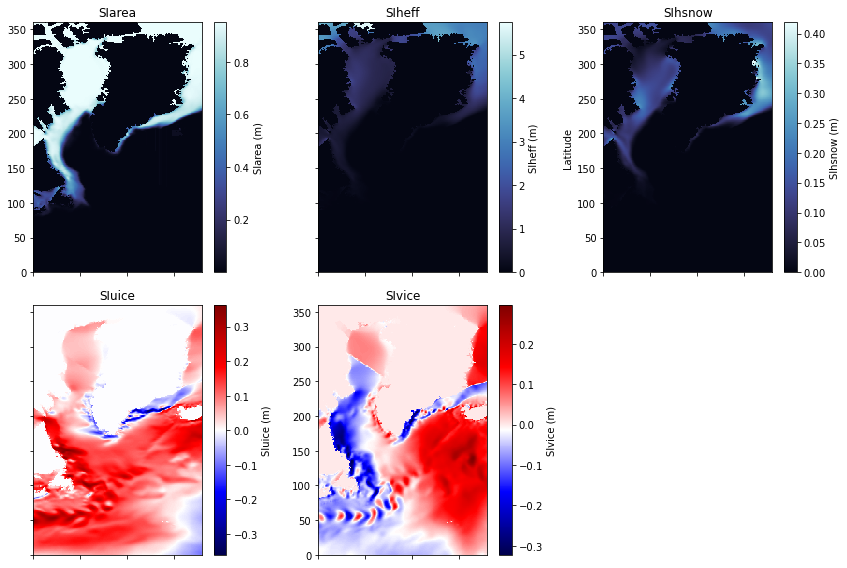

In [31]:
fig = plt.figure(figsize=(12,8))


for i in range(len(variable_names)):
    variable_name = variable_names[i]
    
    CA_init_grid = np.fromfile(os.path.join(input_dir,variable_name+'_IC.bin'),'>f4')

    if variable_name == 'ETAN' or 'SI' in variable_name:
        CA_init_grid = CA_init_grid.reshape((np.shape(XC)[0], np.shape(XC)[1]))
    else:
        CA_init_grid = CA_init_grid.reshape((np.shape(delR)[0],np.shape(XC)[0], np.shape(XC)[1]))
        CA_init_grid = CA_init_grid[10, :, :] # choose just the surface for plotting

    vmin = np.min(CA_init_grid[CA_init_grid!=0])
    vmax = np.max(CA_init_grid[CA_init_grid!=0])
    
    plt.subplot(2,3,i+1)
    C = plt.pcolormesh(CA_init_grid,
                       vmin=vmin,#meta_dict[variable_names[i]][0],
                       vmax=vmax,#meta_dict[variable_names[i]][1],
                       cmap=meta_dict[variable_names[i]][2],
                      shading='auto')
    plt.colorbar(C, label=variable_names[i]+' ('+meta_dict[variable_names[i]][3]+')',fraction=0.26)

    if i<5:
        plt.gca().set_xticklabels([])
    else:
        plt.gca().set_xlabel('Longitude')
    if i%2==1:
        plt.gca().set_yticklabels([])
    if i==7:
        plt.gca().axis('off')
    if i==2:
        plt.gca().set_ylabel('Latitude')
    plt.title(variable_name)

plt.tight_layout()

plt.show()

Looks good! Now we need to make our boundary conditions before we're ready to run the model.

### Step 7: Run-time considerations
To use the grids as initial conditions in the model, I will specify them as "hydrography" conditions. Specifically, I will add the following lines to `PARM05` of the data file:

```
hydrogThetaFile = 'THETA_IC.bin',
hydrogSaltFile = 'SALT_IC.bin',
uVelInitFile = 'UVEL_IC.bin',
vVelInitFile = 'VVEL_IC.bin',
pSurfInitFile = 'ETAN_IC.bin',
```